In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
def transactions_visualization(self, MA_Window=5, transactions=None, title=None, picture_saving_path=None, batch_size=None):
    data = self.data
    trading_strategy = TradingStrategy(data)
    
    if transactions == None:    
        transactions = trading_strategy.trail_function(
            trading_strategy.optimize_trading_rates()["optimized_sell_rate"], 
            trading_strategy.optimize_trading_rates()["optimized_buy_rate"]
        )
        
    # Calculate the moving average with a window of 5
    moving_average = data.rolling(window=MA_Window).mean()
    
    # Create lists to store transaction information
    buy_indices = []
    sell_indices = []
    buy_prices = []
    sell_prices = []
    
    # Keep track of processed transactions with their timestamps
    processed_transactions = []
    for transaction in transactions:
        transaction_type, transaction_price = transaction
        # Find all indices where the price matches the transaction price
        matching_indices = data.index[data == transaction_price].tolist()
        
        # If we've already processed some transactions, find the closest timestamp
        # that occurs after the last processed transaction
        if processed_transactions:
            last_processed_time = processed_transactions[-1][1]
            valid_indices = [idx for idx in matching_indices if idx > last_processed_time]
            if valid_indices:
                index = min(valid_indices)
            else:
                # If no valid indices found after the last transaction,
                # skip this transaction or handle as needed
                continue
        else:
            # For the first transaction, use the first matching index
            index = matching_indices[0]
        
        # Store the processed transaction
        processed_transactions.append((transaction_type, index))
        
        if transaction_type.lower() == 'buy':
            buy_indices.append(index)
            buy_prices.append(data[index])
        elif transaction_type.lower() == 'sell':
            sell_indices.append(index)
            sell_prices.append(data[index])
    
    # Plot the time series
    plt.figure(figsize=(17, 10))
    plt.plot(data, label='Price', color='blue')
    
    # Plot the moving average
    plt.plot(moving_average, label=f'Moving Average (Window={MA_Window})', color='orange')
    
    # Add vertical lines for batch boundaries if batch_size is specified
    if batch_size is not None:
        data_length = len(data)
        batch_boundaries = range(batch_size, data_length, batch_size)
        
        for boundary in batch_boundaries:
            plt.axvline(x=boundary, color='gray', linestyle='--', alpha=1, linewidth=1)
    
    # Plot buy signals
    plt.scatter(buy_indices, buy_prices, marker='^', color='green', s=100, label='Buy Signal')
    plt.scatter(sell_indices, sell_prices, marker='v', color='red', s=100, label='Sell Signal')
    plt.xlabel('Time')
    plt.ylabel('Price')
    
    if title == None:
        plt.title('Time Series with Buy and Sell Signals')
    elif title != None: 
        plt.title(title)
        
    plt.legend()
    
    # Save the plot (optional)
    if picture_saving_path != None:
        filename = os.path.join(picture_saving_path, f"{title}.png")
        plt.savefig(filename)
    
    # Show plot
    plt.show()

In [2]:
class TradingStrategy:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    def __init__(self, data):
        self.data = data
        
    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def trail_function(self, sell_rate, buy_rate):
        
        # Variables for tracking orders and positions
        orders = []
        current_position = "Buy"
        
        # Initial conditions
        interval_max_price = self.data.iloc[0]     # self.data[0]
        stop_price_sell = interval_max_price * (1 - sell_rate)
        stop_price_buy = interval_max_price * (1 + buy_rate)
        
        # Trading loop
        for day_price in self.data:
            if current_position == "Buy":
                if day_price > interval_max_price:
                    interval_max_price = day_price
                    stop_price_sell = interval_max_price * (1 - sell_rate)

                elif day_price <= stop_price_sell:
                    orders.append(("Sell", day_price))
                    current_position = "Sell"
                    interval_max_price = day_price
                    stop_price_buy = interval_max_price * (1 + buy_rate)

            elif current_position == "Sell":
                if day_price < interval_max_price:
                    interval_max_price = day_price
                    stop_price_buy = interval_max_price * (1 + buy_rate)

                elif day_price >= stop_price_buy:
                    orders.append(("Buy", day_price))
                    current_position = "Buy"
                    interval_max_price = day_price
                    stop_price_sell = interval_max_price * (1 - sell_rate)
        return orders
        
    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def calculate_total_profit(self, trade_dict):
        total_profit = 0
        initial_price = None

        for action, price in trade_dict:
            if action == 'Buy':
                initial_price = price
            elif action == 'Sell' and initial_price is not None:
                total_profit += (price / initial_price) - 1
                initial_price = price
        return total_profit
        
    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def calculate_profit(self, trade_dict):
        transaction_returns = []
        initial_price = None

        for action, price in trade_dict:
            if action == 'Buy':
                initial_price = price
            elif action == 'Sell' and initial_price is not None:
                transaction_returns.append((price / initial_price) - 1)
                initial_price = price
        return transaction_returns

    ####################### ####################### ####################### ####################### ####################### ####################### 
    
    def batch_from_end(self, lst, batch_size):
        # Calculate how many elements will be in the first (potentially smaller) batch
        first_batch_size = len(lst) % batch_size
        if first_batch_size == 0:
            first_batch_size = batch_size
        
        # Get the first batch
        result = [lst[:first_batch_size]]
        
        # Get the remaining batches
        for i in range(first_batch_size, len(lst), batch_size):
            result.append(lst[i:i + batch_size])
        
        return result
        
    ####################### ####################### ####################### ####################### ####################### ####################### ########
    
    def batch_separator(self, list_of_batches):
        lines = []
        
        first_batch = list_of_batches[0]
        lines.append(first_batch.iloc[0])
        
        for batch in list_of_batches:
            lines.append(batch.iloc[-1])
            
        return lines
    
    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def optimize_trading_rates(self, buy_rate_start=0.01, data_external=None):
        if data_external is not None and not data_external.empty:
            data = data_external
        else:
            data = self.data

        # Initialize variables
        returns = []
        sell_rate = []
        num_transactions = []
        Trading_Strategy = TradingStrategy(data)
        
        # Calculate returns and transactions for different sell rates
        for i in range(0, 100, 1):  # Using integers and dividing by 100
            i = i / 100.0
            sell_rate.append(i)
            returns.append(Trading_Strategy.calculate_total_profit(Trading_Strategy.trail_function(i, buy_rate_start)))
            num_transactions.append(len(Trading_Strategy.trail_function(i, buy_rate_start)))
    
        # Calculate transaction index for sell rates
        transaction_index = [
            (returns[j] / num_transactions[j]) if num_transactions[j] != 0 else 0 
            for j in range(len(sell_rate))
        ]
    
        # Find the optimized sell rate
        transaction_index_array = np.array(transaction_index)
        index = np.where(transaction_index_array == np.max(transaction_index_array))[0]
        optimized_sell_rate = sell_rate[index[0]]    


        
        # Initialize variables for buy rate optimization
        returns_Buy = []
        buy_rate = []
        num_transactions_Buy = []
    
        # Calculate returns and transactions for different buy rates
        for i in range(0, 100, 1):  # Using integers and dividing by 100
            i = i / 100.0
            buy_rate.append(i)
            returns_Buy.append(Trading_Strategy.calculate_total_profit(Trading_Strategy.trail_function(optimized_sell_rate, i)))
            num_transactions_Buy.append(len(Trading_Strategy.trail_function(optimized_sell_rate, i)))
    
        # Calculate transaction index for buy rates
        transaction_index_Buy = [
            (returns_Buy[j] / num_transactions_Buy[j]) if num_transactions_Buy[j] != 0 else 0 
            for j in range(len(buy_rate))
        ]
    
        # Find the optimized buy rate
        transaction_index_array_Buy = np.array(transaction_index_Buy)
        index = np.where(transaction_index_array_Buy == np.max(transaction_index_array_Buy))[0]
        optimized_buy_rate = buy_rate[index[0]]

        total_optimized_return = Trading_Strategy.calculate_total_profit(Trading_Strategy.trail_function(optimized_sell_rate, optimized_buy_rate))
        num_transaction = len(Trading_Strategy.trail_function(optimized_sell_rate, optimized_buy_rate))



        return {"optimized_sell_rate":optimized_sell_rate, 
                "optimized_buy_rate":optimized_buy_rate, 
                "returns":returns, 
                "returns_Buy":returns_Buy, 
                "num_transactions":num_transactions, 
                "num_transactions_Buy":num_transactions_Buy, 
                "transaction_index":transaction_index, 
                "transaction_index_Buy":transaction_index_Buy, 
                "total_optimized_return":total_optimized_return, 
                "num_transaction": num_transaction}
    
    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def index_visualization(self):
        plt.figure(figsize=(10, 3))  # Adjust size if necessary
        
        # Plot returns on the left y-axis
        plt.plot(trading_strategy.optimize_trading_rates()["returns"], label='returns')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        
        # Create a twin y-axis to plot num_transactions on the right y-axis
        ax2 = plt.twinx()
        ax2.plot(trading_strategy.optimize_trading_rates()["num_transactions"], color='orange', label='num_transactions')
        ax2.set_ylabel('Number of Transactions')
        
        # Add title and legends
        plt.title('Time Series Comparison')
        plt.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Show plot
        plt.show()
        plt.figure(figsize=(10, 3))  # Adjust size if necessary
        
        # Plot returns on the left y-axis
        plt.plot(trading_strategy.optimize_trading_rates()["returns"], label='returns')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        
        # Create a twin y-axis to plot num_transactions on the right y-axis
        ax2 = plt.twinx()
        ax2.plot(trading_strategy.optimize_trading_rates()["transaction_index"], color='orange', label='transaction_index')
        ax2.set_ylabel('transaction_index')
        
        # Add title and legends
        plt.title('Time Series Comparison')
        plt.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Show plot
        plt.show()
        
        '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''' 
        
        plt.figure(figsize=(10, 3))  # Adjust size if necessary
        
        # Plot returns on the left y-axis
        plt.plot(trading_strategy.optimize_trading_rates()["returns_Buy"], label='returns')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        
        # Create a twin y-axis to plot num_transactions on the right y-axis
        ax2 = plt.twinx()
        ax2.plot(trading_strategy.optimize_trading_rates()["num_transactions_Buy"], color='orange', label='num_transactions')
        ax2.set_ylabel('Number of Transactions')
        
        # Add title and legends
        plt.title('Time Series Comparison')
        plt.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Show plot
        plt.show()
        
        plt.figure(figsize=(10, 3))  # Adjust size if necessary
        
        # Plot returns on the left y-axis
        plt.plot(trading_strategy.optimize_trading_rates()["returns_Buy"], label='returns')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        
        # Create a twin y-axis to plot num_transactions on the right y-axis
        ax2 = plt.twinx()
        ax2.plot(trading_strategy.optimize_trading_rates()["transaction_index_Buy"], color='orange', label='transaction_index')
        ax2.set_ylabel('transaction_index')
        
        # Add title and legends
        plt.title('Time Series Comparison')
        plt.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Show plot
        plt.show()

    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def transactions_visualization(self, MA_Window=5, transactions=None, title=None, picture_saving_path=None, batch_size=None):
        data = self.data
        trading_strategy = TradingStrategy(data)
        
        if transactions == None:    
            transactions = trading_strategy.trail_function(
                trading_strategy.optimize_trading_rates()["optimized_sell_rate"], 
                trading_strategy.optimize_trading_rates()["optimized_buy_rate"]
            )
            
        # Calculate the moving average with a window of 5
        moving_average = data.rolling(window=MA_Window).mean()
        
        # Create lists to store transaction information
        buy_indices = []
        sell_indices = []
        buy_prices = []
        sell_prices = []
        
        # Keep track of processed transactions with their timestamps
        processed_transactions = []
        for transaction in transactions:
            transaction_type, transaction_price = transaction
            # Find all indices where the price matches the transaction price
            matching_indices = data.index[data == transaction_price].tolist()
            
            # If we've already processed some transactions, find the closest timestamp
            # that occurs after the last processed transaction
            if processed_transactions:
                last_processed_time = processed_transactions[-1][1]
                valid_indices = [idx for idx in matching_indices if idx > last_processed_time]
                if valid_indices:
                    index = min(valid_indices)
                else:
                    # If no valid indices found after the last transaction,
                    # skip this transaction or handle as needed
                    continue
            else:
                # For the first transaction, use the first matching index
                index = matching_indices[0]
            
            # Store the processed transaction
            processed_transactions.append((transaction_type, index))
            
            if transaction_type.lower() == 'buy':
                buy_indices.append(index)
                buy_prices.append(data[index])
            elif transaction_type.lower() == 'sell':
                sell_indices.append(index)
                sell_prices.append(data[index])
        
        # Plot the time series
        plt.figure(figsize=(17, 10))
        plt.plot(data, label='Price', color='blue')
        
        # Plot the moving average
        plt.plot(moving_average, label=f'Moving Average (Window={MA_Window})', color='orange')
        
        # Add vertical lines for batch boundaries if batch_size is specified
        if batch_size is not None:
            data_length = len(data)
            batch_boundaries = range(batch_size, data_length, batch_size)
            
            for boundary in batch_boundaries:
                plt.axvline(x=boundary, color='gray', linestyle='--', alpha=1, linewidth=1)
        
        # Plot buy signals
        plt.scatter(buy_indices, buy_prices, marker='^', color='green', s=100, label='Buy Signal')
        plt.scatter(sell_indices, sell_prices, marker='v', color='red', s=100, label='Sell Signal')
        plt.xlabel('Time')
        plt.ylabel('Price')
        
        if title == None:
            plt.title('Time Series with Buy and Sell Signals')
        elif title != None: 
            plt.title(title)
            
        plt.legend()
        
        # Save the plot (optional)
        if picture_saving_path != None:
            filename = os.path.join(picture_saving_path, f"{title}.png")
            plt.savefig(filename)
        
        # Show plot
        plt.show()

######################### ###################### ########################## ###################### ######################## #######################

    def moving_window_optimization(self, ma_ranges=(10,40)):
        data = self.data
        trading_strategy = TradingStrategy(data)
        # Starting Grownds
        transaction_index_ls = []
        moving_window_size = []
        
        for i in range(ma_ranges[0], ma_ranges[1]):
            # Determine the batch size
            moving_window = i
            transaction_index_batch_ls = []
            
            # Split the data into batches of moving_window entries
            batches = self.batch_from_end(lst=data,batch_size=i)
            if len(batches[0]) != i:
                batches = batches[1:]
                
            # Access each batch
            for batch in batches:
                trading_strategy = TradingStrategy(batch)
                returns = trading_strategy.calculate_total_profit(trading_strategy.trail_function(trading_strategy.optimize_trading_rates()["optimized_sell_rate"], 
                                                                                                  trading_strategy.optimize_trading_rates()["optimized_buy_rate"]))
                num_transactions = trading_strategy.optimize_trading_rates()["num_transaction"]
        
                if num_transactions != 0:
                    transaction_index_batch_ls.append(returns / num_transactions)
        
                elif num_transactions == 0: 
                    transaction_index_batch_ls.append(0)
            
            # Saving the moving_window result
            transaction_index_ls.append(np.mean(transaction_index_batch_ls))
            moving_window_size.append(moving_window)
            
        # Saving the optimized_moving_window
        transaction_index_ls_array = np.array(transaction_index_ls)
        index = np.where(transaction_index_ls_array == np.max(transaction_index_ls))[0]
        optimized_moving_window = moving_window_size[index[0]]
        optimized_moving_window

        # Creating the optimized batches
        batches = [data[j:j + optimized_moving_window] for j in range(0, len(data), optimized_moving_window)]
        batches = [batch.reset_index(drop=True) for batch in batches]

        # Creating the batch start and end lines by getting the prices at which it happens
        batch_prices = trading_strategy.batch_separator(list_of_batches=batches)
        
        total_trades = []
        for batch in batches:
            trading_strategy = TradingStrategy(batch)
            trades = trading_strategy.trail_function(trading_strategy.optimize_trading_rates()["optimized_sell_rate"], 
                                                     trading_strategy.optimize_trading_rates()["optimized_buy_rate"])

            total_trades = total_trades + trades
            
        total_batches_return = trading_strategy.calculate_total_profit(total_trades) 
        
        return {"total_trades":total_trades,
                "transaction_index_ls_array":transaction_index_ls_array,
                "optimized_moving_window":optimized_moving_window, 
                "moving_window_size":moving_window_size, 
                "total_batches_return":total_batches_return,
                "batch_prices": batch_prices, 
                "batches": batches
               }
    
    ############################# ################################## ############################### ############################### ####################### ##########################
    
    def kairos(self, stock_ticker, trades_1_0=None, graph_pic_saving_path=None):
        data = self.data
        trading_strategy = TradingStrategy(data)

        optimized_moving_window = trading_strategy.moving_window_optimization()["optimized_moving_window"]
        print(optimized_moving_window)
        
        plt.figure(figsize=(10, 5))
        plt.plot(trading_strategy.moving_window_optimization()["transaction_index_ls_array"], 
                 label='transaction_index_ls', marker='o')
        # plt.plot(trading_strategy.moving_window_optimization()["moving_window_size"], label='moving_window_size', marker='x')
        
        # Adding titles and labels
        plt.title('Line Plot of Two Columns')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.legend()
        plt.grid()
        
        # Show plot
        plt.show()

        # Saving the rates for the last moving window, later to be used for the TITLE
        result = trading_strategy.optimize_trading_rates(data_external=data[-optimized_moving_window:].reset_index()[stock_ticker])
        returns = trading_strategy.calculate_total_profit(trading_strategy.moving_window_optimization()["total_trades"])       # trading_strategy.moving_window_optimization(["total_trades"]
        #returns = trading_strategy.moving_window_optimization()["total_batches_return"]
        
        title = f"{stock_ticker}_Buy Rate_{result['optimized_buy_rate']}__Sell Rate_{result['optimized_sell_rate']}__Win{optimized_moving_window}__PrfS_{round(result['total_optimized_return'], 2)}_PrfL_{round(returns, 2)}"  #PrfL_{returns}
        batch_prices = trading_strategy.moving_window_optimization()["batch_prices"]

    
        # Transaction Visualization
        trading_strategy.transactions_visualization(transactions=trading_strategy.moving_window_optimization()["total_trades"], 
                                                    title=title, 
                                                    picture_saving_path=graph_pic_saving_path, 
                                                    batch_size=optimized_moving_window)
        
        if trades_1_0 != None:
            trades = trading_strategy.moving_window_optimization()["total_trades"]
            print(trading_strategy.calculate_total_profit(trades))
            print(" ")
            print(trading_strategy.calculate_profit(trades))
            print(" ")
            print(batch_prices)

################################# ############################### ################################## ############################### #################

21


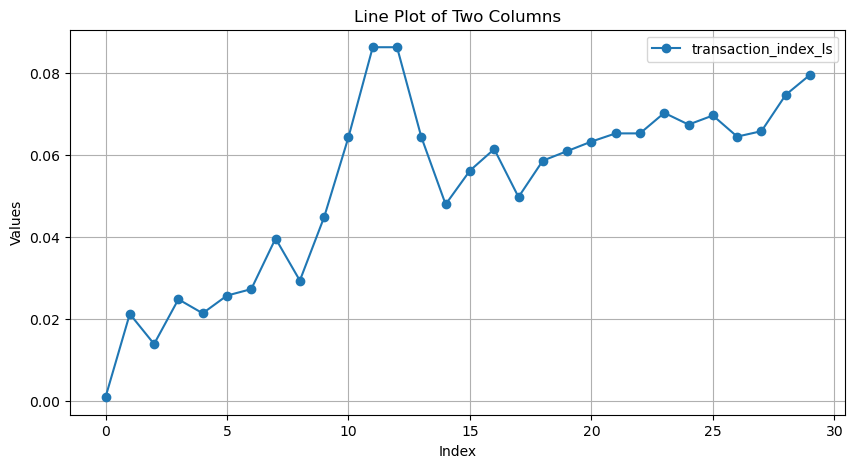

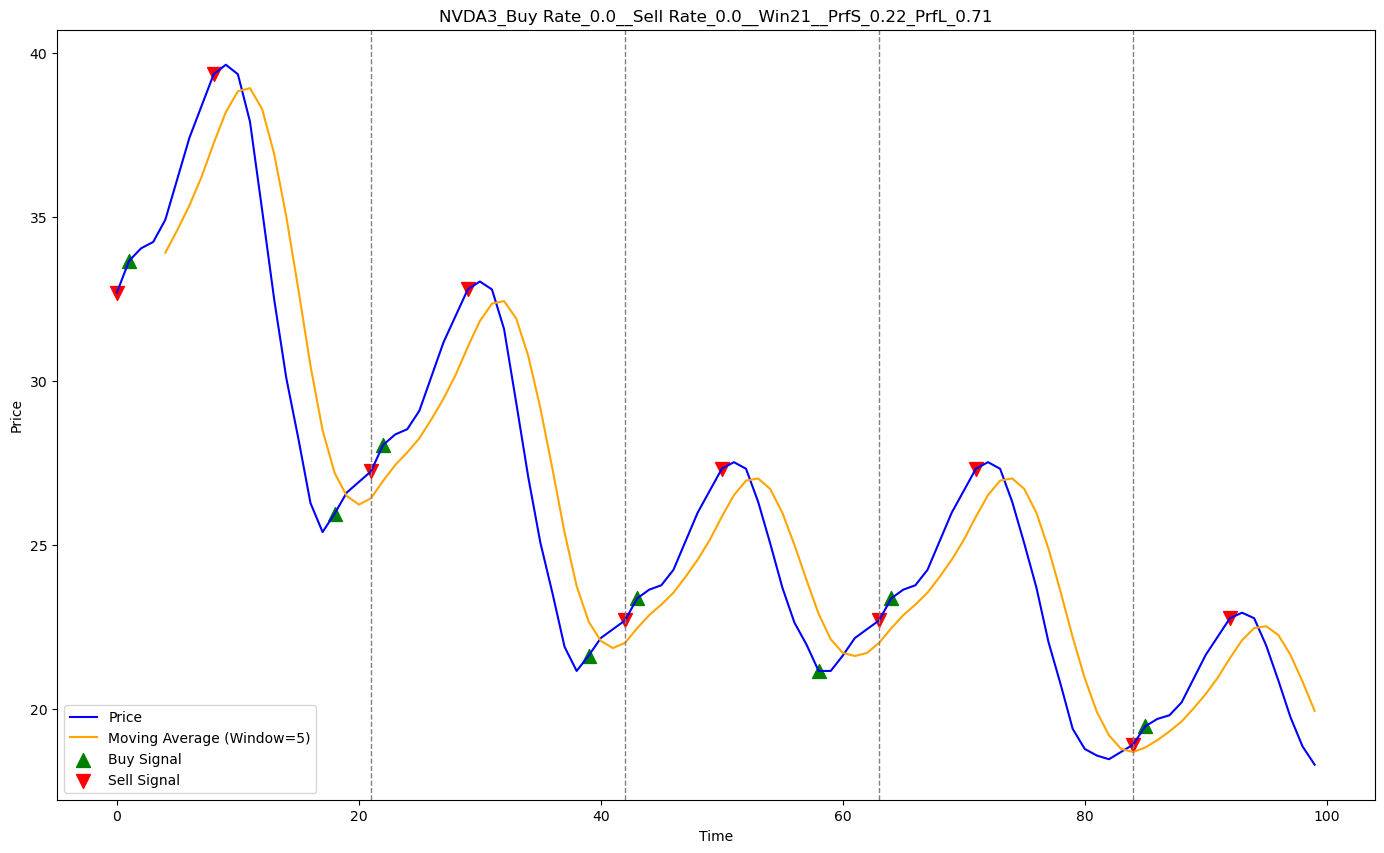

0.7095301846259925
 
[0.1690544412786208, 0.049535603702052455, 0.16905444124848734, 0.04953560393698164, 0.1690544414985431, 0.07278480998454362, 0.1690544414985431, -0.30759803937802266, 0.1690544408562431]
 
[32.69675926, 26.92579733, 22.43816444, 22.43816444, 18.69847037, 18.30775606]


In [6]:
data = pd.read_csv(r"C:\Users\DELL\Desktop\MA Model Data\FakeData.csv") # "C:\Users\DELL\Desktop\MA Model Data\Model Data All_SOX.xlsx" # FakeData.csv
#data = data["Close"]
data = data[-100:].reset_index()
#data = data["ADI"]
stock_ticker = "NVDA3"
stock_data = data[stock_ticker]

tradingStrategy = TradingStrategy(stock_data)
result = tradingStrategy.kairos(stock_ticker=stock_ticker, 
                                trades_1_0=1,
                                graph_pic_saving_path = r"C:\Users\DELL\Desktop\LSTM Data\MA Model\Pics3")

In [5]:
data = pd.read_excel(r"C:\Users\DELL\Desktop\MA Model Data\Model Data All_SOX.xlsx")
#data = data["Close"]
data = data[-100:].reset_index()
#data = data["ADI"]

for stock_ticker in data.columns:
    stock_data = data[stock_ticker]
     
    tradingStrategy = TradingStrategy(stock_data)
    result = tradingStrategy.kairos(stock_ticker=stock_ticker, 
                                    trades_1_0=None,
                                    graph_pic_saving_path = r"C:\Users\DELL\Desktop\LSTM Data\MA Model\Pics5")

KeyboardInterrupt: 